<a href="https://colab.research.google.com/github/mnewman6/Sentiment-Analysis-Project/blob/master/Project2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import pandas as pd
import numpy as np
import pandas_datareader as pdr
import matplotlib.pyplot as plt
import requests 

/usr/local/lib/python3.6/dist-packages/pandas_datareader/compat/__init__.py:7: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  from pandas.util.testing import assert_frame_equal


In [ ]:
import pandas_datareader as pdr
import matplotlib.pyplot as plt

ba_stock = pdr.get_data_yahoo('BA', '2-March-19') 
ba_stock.head()

,High,Low,Open,Close,Volume,Adj Close
Date,,,,,,
2019-03-04,444.500000,426.630005,443.220001,432.690002,5971000.0,422.555725
2019-03-05,433.850006,428.640015,431.040009,430.119995,2844300.0,420.045898
2019-03-06,432.000000,422.079987,429.700012,424.459991,4159400.0,414.518463
2019-03-07,434.350006,416.440002,423.359985,422.559998,4893600.0,412.662964
2019-03-08,423.429993,415.500000,416.769989,422.540009,3794900.0,412.643463


In [ ]:
ba_stock['9_SMA'] = ba_stock['Close'].rolling(window=9).mean()
ba_stock['50_SMA'] = ba_stock['Close'].rolling(window=50).mean()

ba_stock = ba_stock[ba_stock['50_SMA'].notna()]

# SMA trade signals
Trade_Buy=[]
Trade_Sell=[]
for i in range(len(ba_stock)-1):
    if ((ba_stock['9_SMA'].values[i] < ba_stock['50_SMA'].values[i]) & (ba_stock['9_SMA'].values[i+1] > ba_stock['50_SMA'].values[i+1])):
        print("Trade Signal for {row} is Buy.".format(row=ba_stock.index[i].date()))
        Trade_Buy.append(i)
    elif ((ba_stock['9_SMA'].values[i] > ba_stock['50_SMA'].values[i]) & (ba_stock['9_SMA'].values[i+1] < ba_stock['50_SMA'].values[i+1])):
        print("Trade Signal for {row} is Sell.".format(row=ba_stock.index[i].date()))
        Trade_Sell.append(i)

Trade Signal for 2019-06-21 is Buy.
Trade Signal for 2019-07-09 is Sell.
Trade Signal for 2019-07-12 is Buy.
Trade Signal for 2019-07-30 is Sell.
Trade Signal for 2019-08-29 is Buy.
Trade Signal for 2019-10-21 is Sell.
Trade Signal for 2019-11-20 is Buy.
Trade Signal for 2019-12-04 is Sell.
Trade Signal for 2020-02-11 is Buy.
Trade Signal for 2020-02-25 is Sell.
Trade Signal for 2020-05-26 is Buy.


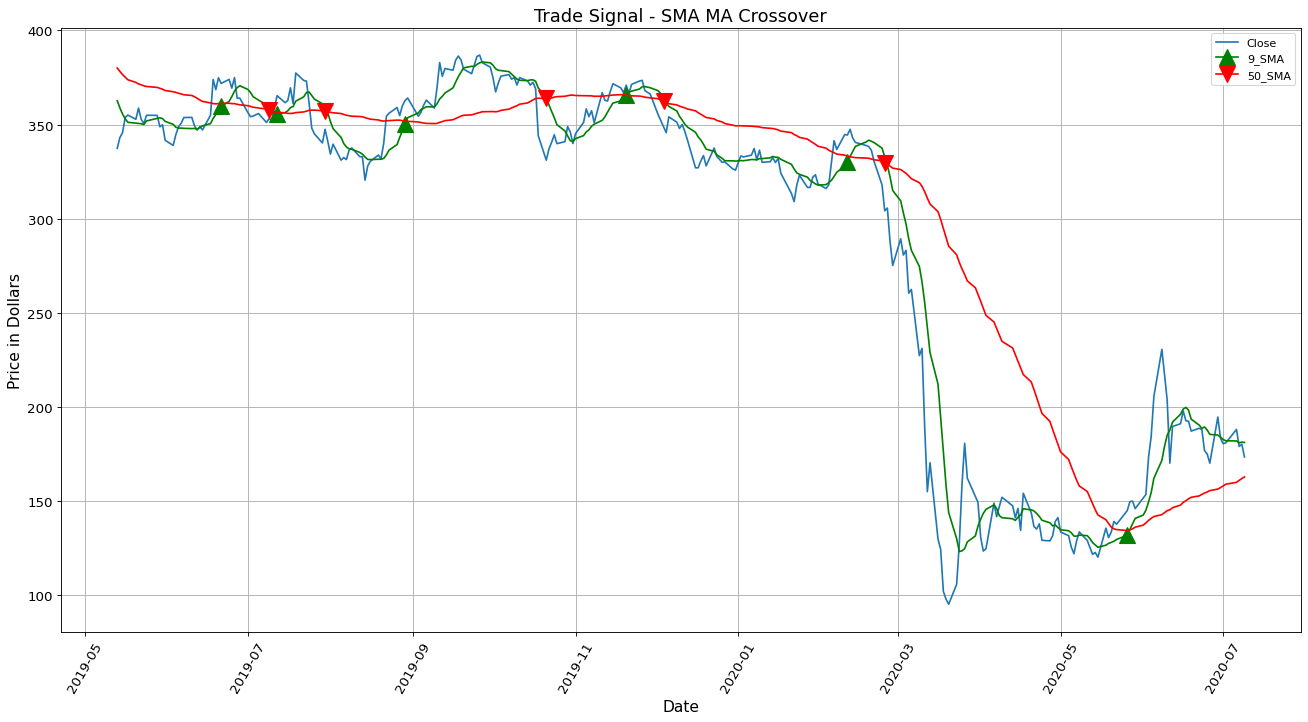

In [ ]:
plt.figure(figsize=(20, 10),dpi=80)
plt.plot(ba_stock.index, ba_stock['Close'])
plt.plot(ba_stock.index, ba_stock['9_SMA'],'-^', markevery=Trade_Buy, ms=15, color='green')
plt.plot(ba_stock.index, ba_stock['50_SMA'],'-v', markevery=Trade_Sell, ms=15, color='red')
plt.xlabel('Date',fontsize=14)
plt.ylabel('Price in Dollars', fontsize = 14)
plt.xticks(rotation='60',fontsize=12)
plt.yticks(fontsize=12)
plt.title('Trade Signal - SMA MA Crossover', fontsize = 16)
plt.legend(['Close','9_SMA','50_SMA'])
plt.grid()
plt.show() 

In [ ]:
# Define API
url = 'https://newsapi.org/v2/everything?'

# number of returns
parameters = {
    'q': 'Boeing', # query phrase
    'sortBy': 'popularity', # articles from popular sources and publishers come first
    'pageSize': 100,  # maximum is 100 for developer version
    'apiKey': '41f82539f4ec4ba79932a9ce234f115a', # your own API key
}

# Make the request
response = requests.get(url, params=parameters)

# Convert the response to JSON format and store it in dataframe
data = pd.DataFrame(response.json())

article_df = pd.concat([data['articles'].apply(pd.Series)], axis=1)

news_article = article_df.loc[:,['publishedAt','title']]
news_article['publishedAt'] = pd.to_datetime(news_article['publishedAt'])
news_article.sort_values(by='publishedAt',inplace=True)

# Import BDay to determine business day's dates
from pandas.tseries.offsets import BDay
# to get the business day for which particular news headline should be used to make trade signal
def get_trade_open(date):
    curr_date_open = pd.to_datetime(date).floor('d').replace(hour=13,minute=30) - BDay(0)
    curr_date_close = pd.to_datetime(date).floor('d').replace(hour=20,minute=0) - BDay(0)
    
    prev_date_close = (curr_date_open - BDay()).replace(hour=20,minute=0)
    next_date_open = (curr_date_close + BDay()).replace(hour=13,minute=30)
    
    if ((pd.to_datetime(date)>=prev_date_close) & (pd.to_datetime(date)<curr_date_open)):
        return curr_date_open
    elif ((pd.to_datetime(date)>=curr_date_close) & (pd.to_datetime(date)<next_date_open)):
        return next_date_open
    else:
        return None
      
 # Apply the above function to get the trading time for each news headline
news_article["trading_time"] = news_article["publishedAt"].apply(get_trade_open)

news_article = news_article[pd.notnull(news_article['trading_time'])]
news_article['Date'] = pd.to_datetime(pd.to_datetime(news_article['trading_time']).dt.date)

In [ ]:
import nltk
nltk.download('vader_lexicon')

[nltk_data] Downloading package vader_lexicon to /root/nltk_data...


True

In [ ]:
from nltk.sentiment.vader import SentimentIntensityAnalyzer

analyzer = SentimentIntensityAnalyzer()

/usr/local/lib/python3.6/dist-packages/nltk/twitter/__init__.py:20: UserWarning: The twython library has not been installed. Some functionality from the twitter package will not be available.
  warnings.warn("The twython library has not been installed. "


In [ ]:
cs = []
for row in range(len(news_article)):
    cs.append(analyzer.polarity_scores(news_article['title'].iloc[row])['compound'])

news_article['compound_vader_score'] = cs
news_article = news_article[(news_article[['compound_vader_score']] != 0).all(axis=1)].reset_index(drop=True)

news_article.tail()

,publishedAt,title,trading_time,Date,compound_vader_score
27,2020-07-07 11:25:00+00:00,Leasing firm Avolon cancels another 27 Boeing ...,2020-07-07 13:30:00+00:00,2020-07-07,-0.2263
28,2020-07-07 22:07:00+00:00,Investigation of Botched Starliner Test Expose...,2020-07-08 13:30:00+00:00,2020-07-08,-0.5106
29,2020-07-07 23:29:00+00:00,Boeing settles nearly all Lion Air 737 MAX cra...,2020-07-08 13:30:00+00:00,2020-07-08,-0.4019
30,2020-07-08 02:49:00+00:00,Boeing settles nearly all Lion Air 737 MAX cra...,2020-07-08 13:30:00+00:00,2020-07-08,-0.4019
31,2020-07-08 09:29:53+00:00,Probe of failed Boeing Starliner launch finds ...,2020-07-08 13:30:00+00:00,2020-07-08,-0.7184


In [ ]:
unique_dates = news_article['Date'].unique()
grouped_dates = news_article.groupby(['Date'])
keys_dates = list(grouped_dates.groups.keys())

max_cs = []
min_cs = []

for key in grouped_dates.groups.keys():
    data = grouped_dates.get_group(key)
    if data["compound_vader_score"].max() > 0:
        max_cs.append(data["compound_vader_score"].max())
    elif data["compound_vader_score"].max() < 0:
        max_cs.append(0)
    
    if data["compound_vader_score"].min() < 0:
        min_cs.append(data["compound_vader_score"].min())
    elif data["compound_vader_score"].min() > 0:
        min_cs.append(0)
    
vader_scores_dict = {'Date':keys_dates,'max_scores':max_cs,'min_scores':min_cs}
vader_scores_df = pd.DataFrame(vader_scores_dict)

In [ ]:
final_scores = []
for i in range(len(vader_scores_df)):
    final_scores.append(vader_scores_df['max_scores'].values[i] + vader_scores_df['min_scores'].values[i])

vader_scores_df['final_scores'] = final_scores

vader_scores_df.head()

,Date,max_scores,min_scores,final_scores
0,2020-06-10,0.6249,0.0000,0.6249
1,2020-06-24,0.4404,-0.6597,-0.2193
2,2020-06-26,0.0000,-0.2732,-0.2732
3,2020-06-29,0.5859,0.0000,0.5859
4,2020-06-30,0.2960,-0.6249,-0.3289


In [ ]:
# VADER trade Signal - with threshold
vader_Buy=[]
vader_Sell=[]
for i in range(len(vader_scores_df)):
    if vader_scores_df['final_scores'].values[i] > 0.20:
        print("Trade Signal for {row} is Buy.".format(row=vader_scores_df['Date'].iloc[i].date()))
        vader_Buy.append(vader_scores_df['Date'].iloc[i].date())
    elif vader_scores_df['final_scores'].values[i] < -0.20:
        print("Trade Signal for {row} is Sell.".format(row=vader_scores_df['Date'].iloc[i].date()))
        vader_Sell.append(vader_scores_df['Date'].iloc[i].date())

Trade Signal for 2020-06-10 is Buy.
Trade Signal for 2020-06-24 is Sell.
Trade Signal for 2020-06-26 is Sell.
Trade Signal for 2020-06-29 is Buy.
Trade Signal for 2020-06-30 is Sell.
Trade Signal for 2020-07-02 is Sell.
Trade Signal for 2020-07-03 is Sell.
Trade Signal for 2020-07-06 is Sell.
Trade Signal for 2020-07-07 is Sell.
Trade Signal for 2020-07-08 is Sell.


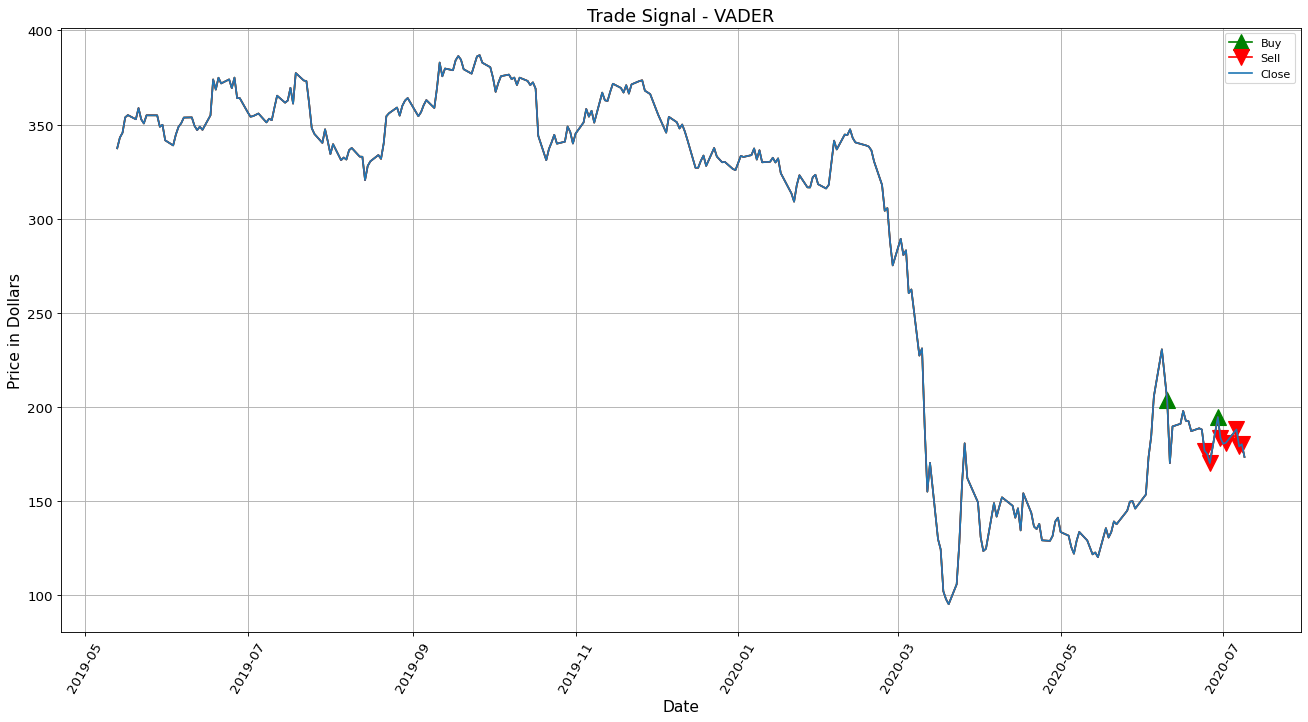

In [ ]:
vader_buy = []
for i in range(len(ba_stock)):
    if ba_stock.index[i].date() in vader_Buy:
        vader_buy.append(i)
        
vader_sell = []
for i in range(len(ba_stock)):
    if ba_stock.index[i].date() in vader_Sell:
        vader_sell.append(i)
        
plt.figure(figsize=(20, 10),dpi=80)
plt.plot(ba_stock.index, ba_stock['Close'],'-^', markevery=vader_buy, ms=15, color='green')
plt.plot(ba_stock.index, ba_stock['Close'],'-v', markevery=vader_sell, ms=15, color='red')
plt.plot(ba_stock.index, ba_stock['Close'])
plt.xlabel('Date',fontsize=14)
plt.ylabel('Price in Dollars', fontsize = 14)
plt.xticks(rotation='60',fontsize=12)
plt.yticks(fontsize=12)
plt.title('Trade Signal - VADER', fontsize = 16)
plt.legend(['Buy','Sell','Close'])
plt.grid()
plt.show()

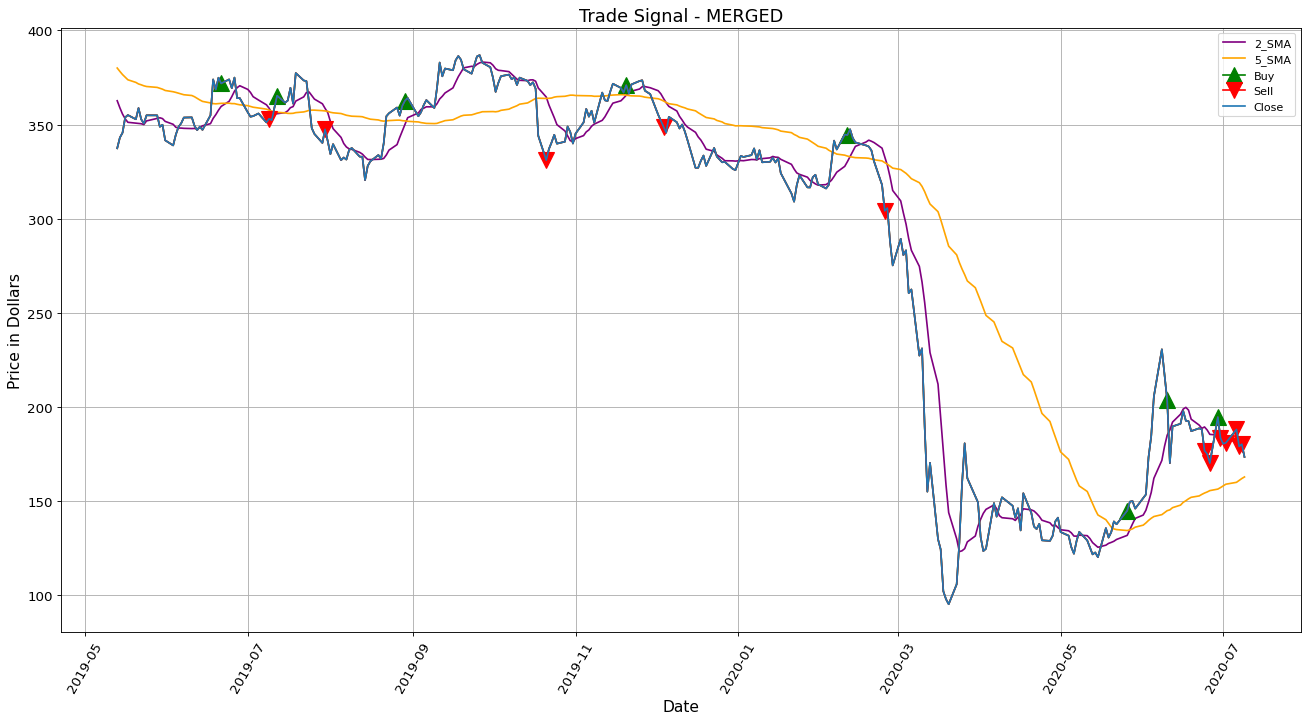

In [ ]:
#prioritising SMA signals
final_buy = list(set(Trade_Buy + vader_buy) - set(Trade_Sell)) 
final_sell = list(set(Trade_Sell + vader_sell) - set(Trade_Buy))

plt.figure(figsize=(20, 10),dpi=80)
plt.plot(ba_stock.index, ba_stock['9_SMA'], color='purple')
plt.plot(ba_stock.index, ba_stock['50_SMA'], color='orange')
plt.plot(ba_stock.index, ba_stock['Close'],'-^', markevery=final_buy, ms=15, color='green')
plt.plot(ba_stock.index, ba_stock['Close'],'-v', markevery=final_sell, ms=15, color='red')
plt.plot(ba_stock.index, ba_stock['Close'])
plt.xlabel('Date',fontsize=14)
plt.ylabel('Price in Dollars', fontsize = 14)
plt.xticks(rotation='60',fontsize=12)
plt.yticks(fontsize=12)
plt.title('Trade Signal - MERGED', fontsize = 16)
plt.legend(['2_SMA','5_SMA','Buy','Sell','Close'])
plt.grid()
plt.show()